# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [8]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [9]:
keepDuplicatesStrategy = "first"

def displayDataFrameLength(dataFrame, dataFrameName = "df"):   
    """ Display length of the dataframe """
    print("No. of rows in {}: {}".format(dataFrameName, len(dataFrame)))
    
def displayDuplicateRowsCount(dataFrame, dataFrameName = "df", keep = keepDuplicatesStrategy):
    """ Display count of duplicate rows in dataframe """
    print("No. of duplicate rows in {}: {}".format(dataFrameName, 
                                                   len(getDuplicateRows(dataFrame, keepDuplicatesStrategy))))    
    
# Note: preliminary analysis shows that duplicates can be found by id    
def getDuplicateRows(dataFrame, keep = keepDuplicatesStrategy):
    """ Get the duplicate rows in the dataframe """
    return dataFrame[dataFrame.duplicated(keep = keepDuplicatesStrategy)]

In [10]:
# load messages dataset
messages = pd.read_csv("messages.csv")

# Note: Fill missing values of original untranslated message with translated message and appended id. 
# Reasoning: 
#    1. We are not using original now, but maybe it's important later to see the original message so we keep it for now. 
#    2. Better to remove as many NaN values as possible
messages["original"].fillna(messages["message"] + ";id-{}".format(messages["id"]), inplace = True)

displayDataFrameLength(messages, "messages")
displayDuplicateRowsCount(messages, "messages")

print(messages["genre"].value_counts())
messages.head()

No. of rows in messages: 26248
No. of duplicate rows in messages: 68
news      13068
direct    10782
social     2398
Name: genre, dtype: int64


,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [11]:
# load categories dataset
categories = pd.read_csv('categories.csv')
displayDataFrameLength(categories, "categories")
displayDuplicateRowsCount(categories, "categories")
categories.head()

No. of rows in categories: 26248
No. of duplicate rows in categories: 32


,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [12]:
# merge datasets
df = messages.merge(categories)
df.head()

displayDataFrameLength(df)

No. of rows in df: 26386


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{'help': 330, 'need': 309, 'please': 287, 'food': 255, 'water': 196, 'people': 194, 'u': 174, 'thank': 76, 'port': 74, 'area': 73, 'street': 73, 'house': 71, 'au': 69, 'know': 68, 'like': 68, 'lot': 67, 'message': 66, 'prince': 65, 'call': 64, 'would': 64}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

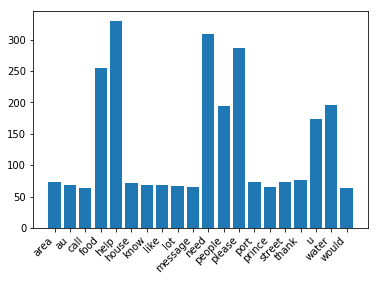

In [53]:
import nltk, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
       
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

def tokenize(text):
    """ Tokenize """    
    # Normalize text
    # Replace non-alphanumeric characters with space, convert to lower and remove trailing spaces 
    text = re.sub("[^a-zA-Z09]", " ", text).lower().strip()
    # To be extra-clean remove double spaces
    text = re.sub("\s{2,}", " ", text)    
    # After normalization, tokenize text into tokens, remove stop words and lemmatize
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words("english")]    
    tokens = [word for word in tokens if word not in ["0", "00"]]    
    return tokens   

import operator
import itertools
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer = tokenize)   
cv_fit = cv.fit_transform(df["message"].loc[:1000])    
word_list = cv.get_feature_names();    
count_list = cv_fit.toarray().sum(axis=0)    

word_dict = dict(zip(word_list, count_list))
sorted_d = dict(sorted(word_dict.items(), key = operator.itemgetter(1), reverse = True))

sorted20 = dict(itertools.islice(sorted_d.items(), 20))

keys20 = sorted20.keys()
values20 = sorted20.values()

import matplotlib.pyplot as plt

plt.bar(keys20, values20)
plt.xticks(rotation=45, ha="right")

### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [6]:
# create a dataframe of the 36 individual category columns
categories = df["categories"].str.split(";", expand = True)
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [7]:
# select the first row of the categories dataframe
categoryNameParts = df["categories"][0].split(";")
categoryColumnNames = []

for categoryNamePart in categoryNameParts:
    categoryColumnNames.append(categoryNamePart.split("-")[0])

# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing
print(categoryColumnNames)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [8]:
# rename the columns of `categories`
categories.columns = categoryColumnNames
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [9]:
for column in categories:
    
    # set each value to be the last character of the string
    categories[column] = categories[column].str.split("-").str[1]
    
    # convert column from string to numeric
    categories[column] = pd.to_numeric(categories[column]) 
    
#categories.dtypes
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print(np.unique(categories.related))

[0 1 2]


In [11]:
# Additional fixes

# Fix 1
# There are non-binary values present, which will obviously cause problems later. 
# Remove these by assuming 1 was intended for 2 and replacing them.
print("Unique values before: {}".format(np.unique(categories["related"])))
categories.related.replace(2, 1, inplace = True)
print("Unique values after: {}".format(np.unique(categories)))

# Fix 2
# Column "child_alone" has exclusively 0 values.
# This can throw an error later when we fit a multilabel classifier (f.i. SVC: Expected more than one classes, got 1)
# Also, if only 0 values are present, there is nothing to learn and nothing to predict.
# Therefore in an additional step here, we check for any such columns and remove them before proceeding further.
#
# Note: Rubric states there must be 36 columns in the result. Skipping Fix #2 for final solution, putting it in ML pipeline instead.
#
def getInvalidColumns(df):
    """ Get columns with only one class """
    invalidColumns = []
    for categoryColumn in df.columns:
        if ((df[categoryColumn] == 0).all() or (df[categoryColumn] == 1).all()):
            invalidColumns.append(categoryColumn)
    return invalidColumns
        
#invalidColumns = getInvalidColumns(categories)
#if (len(invalidColumns) > 0):
#    for invalidColumn in invalidColumns:
#        categories.drop(invalidColumn, axis = "columns", inplace = True)
        
print (categories.shape)   

Unique values before: [0 1 2]
Unique values after: [0 1]
(26386, 36)


### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [12]:
# drop the original categories column from `df`
df.drop(["categories"], axis = "columns", inplace=True)
df.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [13]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis =  "columns", sort = False)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [14]:
# check number of duplicates   
rowsBeforeRemovingDuplicates = len(df)
print(f"No. of rows before removing duplicates: {rowsBeforeRemovingDuplicates}")
displayDuplicateRowsCount(df)

No. of rows before removing duplicates: 26386
No. of duplicate rows in df: 171


In [15]:
# drop duplicates
droppedDf = df.drop_duplicates(keep = keepDuplicatesStrategy)
rowsToDropCount = len(df) - len(droppedDf)
print(f"Going to drop {rowsToDropCount} duplicate rows.")
df.drop_duplicates(keep = keepDuplicatesStrategy, inplace = True)

Going to drop 171 duplicate rows.


In [16]:
# check number of duplicates
displayDuplicateRowsCount(df)
rowsAfterRemovingDuplicates = len(df)
print(f"No. of rows: {rowsAfterRemovingDuplicates}")

assert rowsToDropCount + rowsAfterRemovingDuplicates == rowsBeforeRemovingDuplicates, \
    "Error in dropping duplicates - Before / After counts didn't add up!"

No. of duplicate rows in df: 0
No. of rows: 26215


### 7. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [17]:
engine = create_engine('sqlite:///DisasterResponse.db')

#print(engine.engine.table_names())
#dfExisting = pd.read_sql('select * from Message limit 20', engine)
#print(dfExisting)
with engine.connect() as conn:
    conn.execute("DROP TABLE IF EXISTS Message;")
    conn.execute("DROP TABLE IF EXISTS CategorizedResponse;")
#print(engine.engine.table_names())

df.to_sql('CategorizedResponse', engine, index = False)

print(engine.engine.table_names())

['CategorizedResponse']


In [18]:
# Test selection from new database

selectedDf = pd.read_sql("SELECT * FROM CategorizedResponse", engine)
recordsCount = len(selectedDf)

print (f"Record count is {recordsCount}")

assert recordsCount == rowsAfterRemovingDuplicates, \
    "Error writing to database, row counts did not match!"

selectedDf.head(10)

Record count is 26215


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


### 8. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.